In [25]:
import sys
import os
sys.path.append("/Users/sean/Desktop/Repos/LAB-positioner-tilt/scripts")
import spotfinderB as spotB
from astropy.stats import sigma_clipped_stats
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.optimize import curve_fit
import random
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import pandas as pd

In [2]:
names = ['peaks',"x","y","fwhm","energy","radius"]
formats = ['f8','f8','f8','f8','f8','f8']
nm_fm = []
for n,f in zip(names,formats):
    nm_fm.append((n,f))

theta=np.arange(0,2*np.pi,step=0.01)

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# Using the lower power LED

## Precision test on a single image
Goal: repeat the spotfinding algorithm on a single image to check that the measurement is repeatable

In [396]:
baseDir = "/Users/sean/Desktop/Repos/ThorlabsImages/imgs/lightsOn_LEDOff/"

In [602]:
%%time

allCents = np.array([])
# chosenFile = random.sample(os.listdir(baseDir),1)[0]
print(f"Chosen file: {chosenFile}")
n=1
for _n in range(n):
    finder = spotB.SpotFinder(file_path=baseDir+chosenFile,max_counts=3000,min_energy=25,fboxsize=136)
    centroid = finder.get_centroids()
    centroid['radius'] = centroid['fwhm']/(2*np.sqrt(2*np.log(2)))
    for k,v in zip(centroid.keys(),centroid.values()):
        centroid[k] = v[0]
    allCents = np.append(allCents,centroid)

Chosen file: 20251119_151730_10000.tif
CPU times: user 642 ms, sys: 71.2 ms, total: 713 ms
Wall time: 720 ms


In [603]:
vals = [tuple(x.values()) for x in allCents]
centroidResult = np.array(vals,dtype=nm_fm)

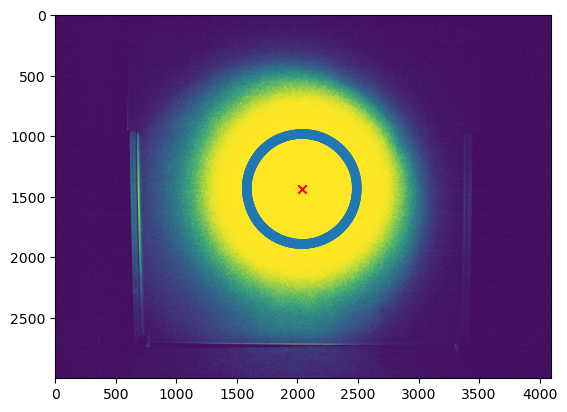

In [604]:
fig,ax = plt.subplots()
theta=np.arange(0,2*np.pi,step=0.01)
ax.imshow(Image.open(baseDir+chosenFile),vmin=5,vmax=15)
ax.scatter(centroidResult['x'],centroidResult['y'],marker='x',color='red')
for x,y,r in zip(centroidResult['x'],centroidResult['y'],centroidResult['radius']):
    ax.scatter(x+r*np.cos(theta),y+r*np.sin(theta),ls='--')

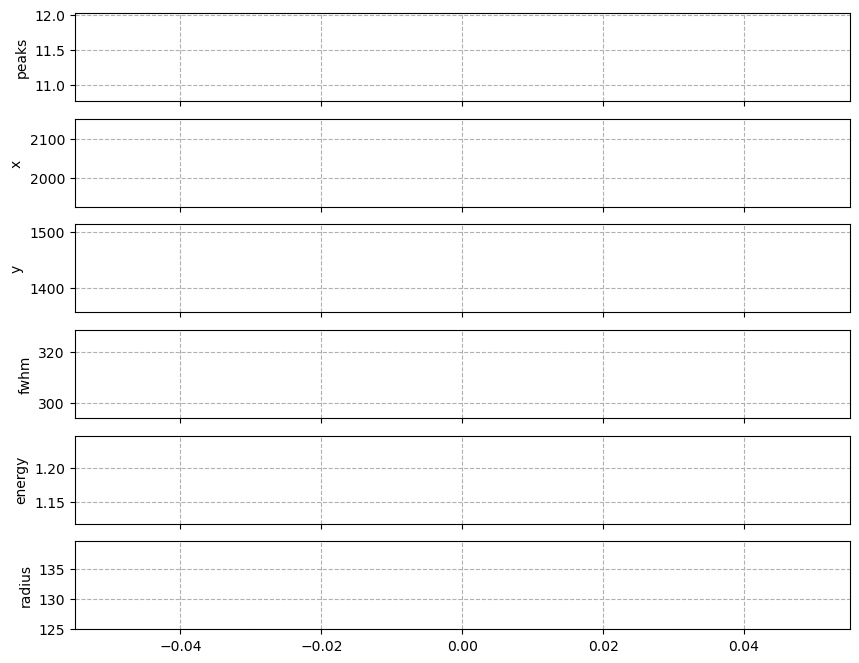

In [570]:
fig,axs = plt.subplots(6,figsize=[10,8],sharex=True)
for ax,name in zip(axs.flatten(),names):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')

Text(0.5, 0, 'Image number')

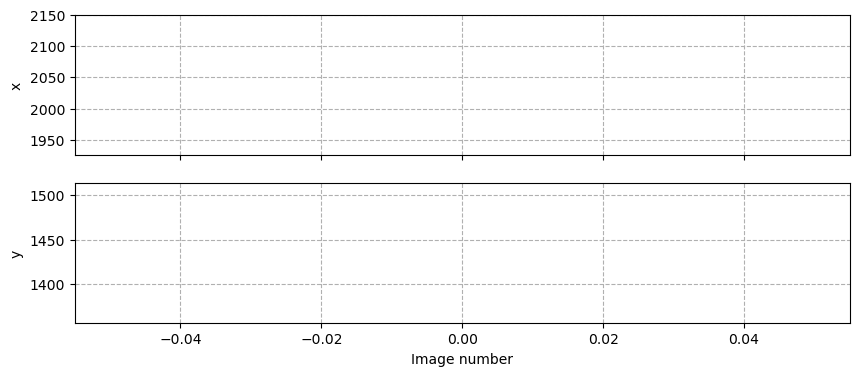

In [571]:
fig,axs = plt.subplots(2,1,figsize=[10,4],sharex=True)
for ax,name in zip(axs.flatten(),["x","y"]):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')
ax.set_xlabel("Image number")

For value peaks: 6.987, 6.987, 6.987, range over 1-sigma interval: 0.000000000000
For value x: 2039.483, 2039.483, 2039.483, range over 1-sigma interval: 0.000000000000
For value y: 1432.433, 1432.433, 1432.433, range over 1-sigma interval: 0.000000000000
For value fwhm: 231.112, 231.112, 231.112, range over 1-sigma interval: 0.000000000000
For value energy: 0.538, 0.538, 0.538, range over 1-sigma interval: 0.000000000000
For value radius: 98.144, 98.144, 98.144, range over 1-sigma interval: 0.000000000000


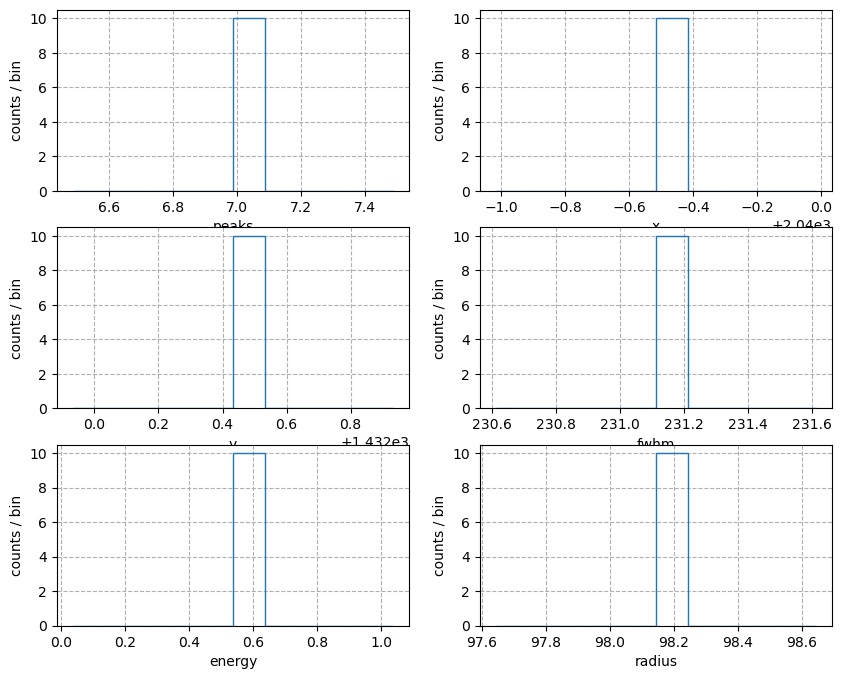

In [566]:
fig,axs = plt.subplots(3,2,figsize=[10,8])
for ax,name in zip(axs.flatten(),names):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step')
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.12f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')

## For multiple images

In [619]:
%%time

allCents = np.array([])
for f in os.listdir(baseDir):
    file_name = baseDir+f
    finder = spotB.SpotFinder(file_path=file_name,max_counts=3000,min_energy=50,fboxsize=150)
    centroid = finder.get_centroids()
    centroid['radius'] = centroid['fwhm']/(2*np.sqrt(2*np.log(2)))
    for k,v in zip(centroid.keys(),centroid.values()):
        centroid[k] = v[0]
    allCents = np.append(allCents,centroid)

CPU times: user 1min 14s, sys: 6.96 s, total: 1min 21s
Wall time: 1min 25s


In [620]:
vals = [tuple(x.values()) for x in allCents]
centroidResult = np.array(vals,dtype=nm_fm)

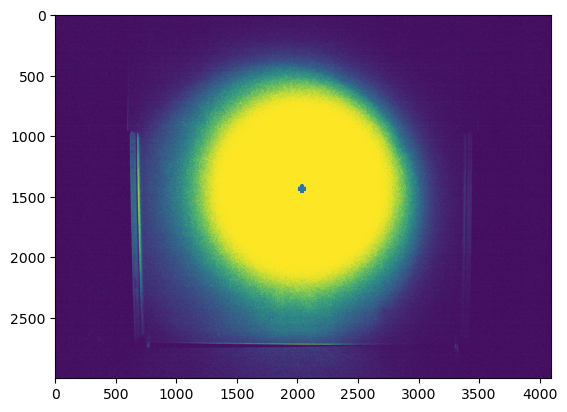

In [621]:
radii_plt=False
fig,ax = plt.subplots()
ax.imshow(Image.open(file_name),vmin=5,vmax=15)
ax.scatter(centroidResult['x'],centroidResult['y'],marker='+')
if radii_plt:
    for x,y,r in zip(centroidResult['x'],centroidResult['y'],centroidResult['radius']):
        ax.scatter(x+r*np.cos(theta),y+r*np.sin(theta),ls='--')

Text(0.5, 0, 'Image number')

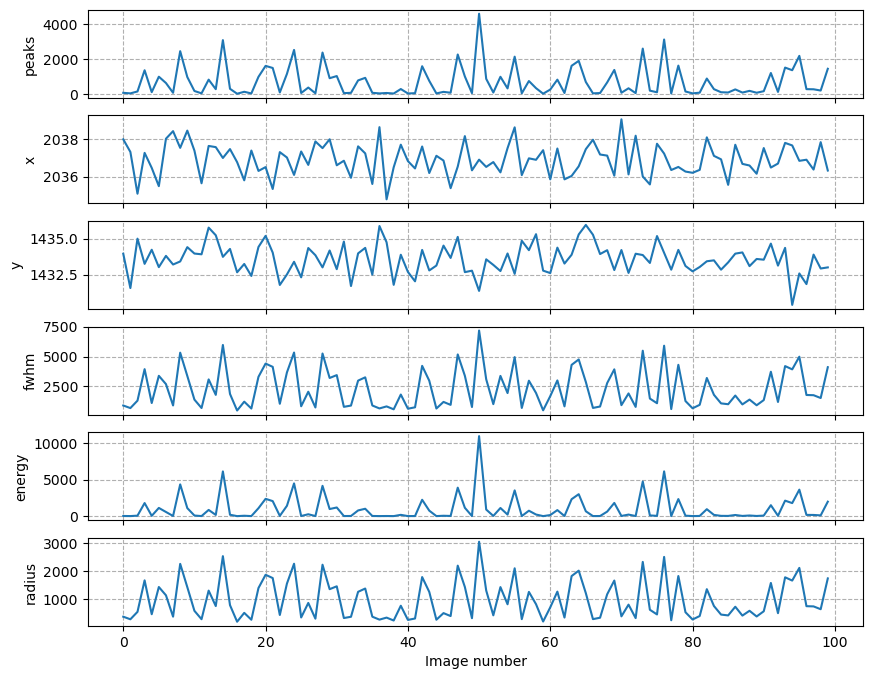

In [622]:
fig,axs = plt.subplots(6,figsize=[10,8],sharex=True)
for ax,name in zip(axs.flatten(),names):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')
ax.set_xlabel("Image number")

Text(0.5, 0, 'Image number')

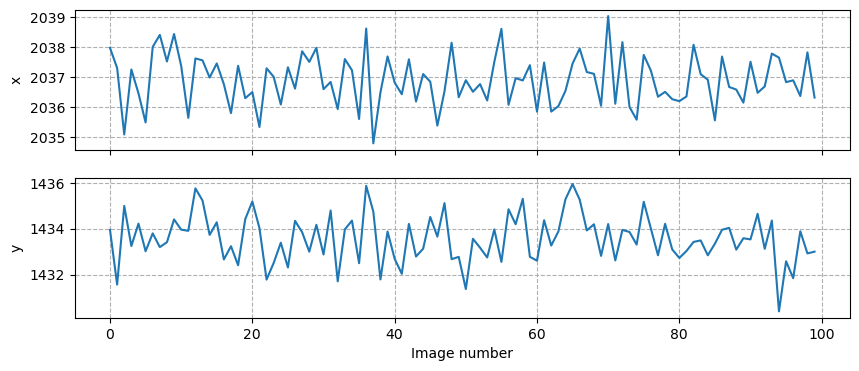

In [623]:
fig,axs = plt.subplots(2,1,figsize=[10,4],sharex=True)
for ax,name in zip(axs.flatten(),["x","y"]):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')
ax.set_xlabel("Image number")

For value peaks: 59.488, 283.134, 1500.708, range over 1-sigma interval: 1441.220000833912
For value x: 2036.072, 2036.870, 2037.700, range over 1-sigma interval: 1.627268211900
For value y: 1432.656, 1433.573, 1434.430, range over 1-sigma interval: 1.774427207006
For value fwhm: 792.856, 1780.054, 4146.688, range over 1-sigma interval: 3353.832357386396
For value energy: 15.841, 168.284, 2074.385, range over 1-sigma interval: 2058.544137875244
For value radius: 336.695, 755.919, 1760.936, range over 1-sigma interval: 1424.241467819812


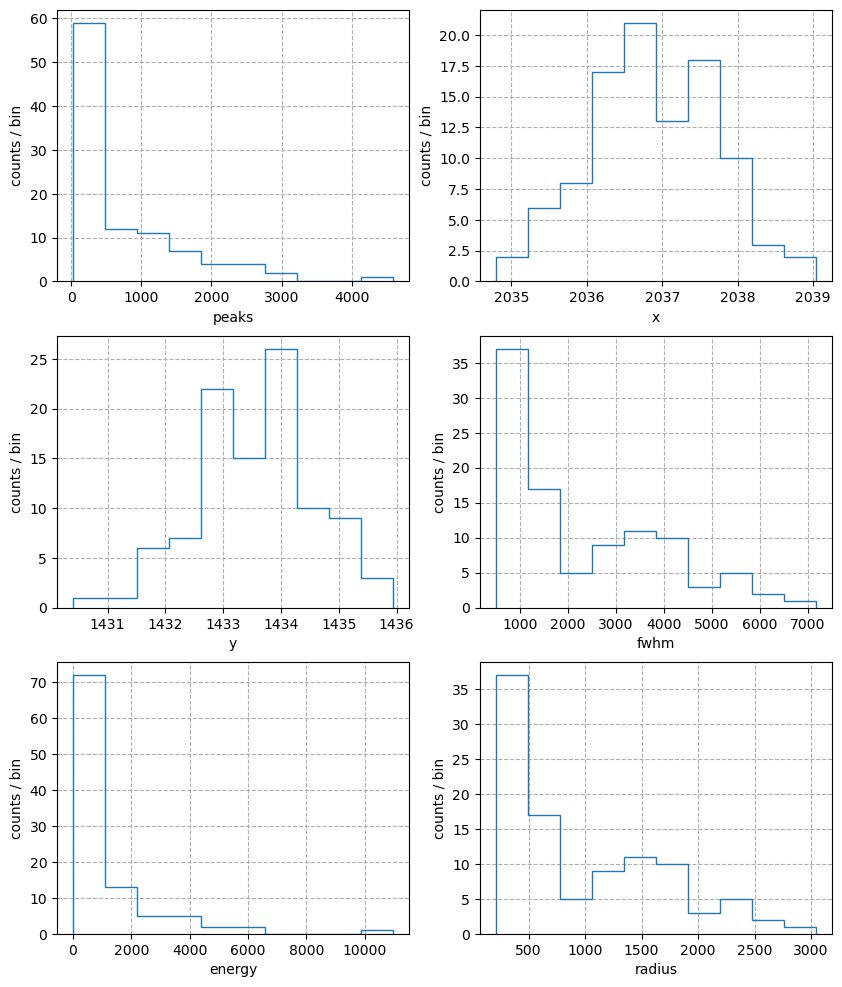

In [624]:
fig,axs = plt.subplots(3,2,figsize=[10,12])
for ax,name in zip(axs.flatten(),names):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step')
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.12f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')

For value x: 2036.072, 2036.870, 2037.700, range over 1-sigma interval: 1.627268211900
For value y: 1432.656, 1433.573, 1434.430, range over 1-sigma interval: 1.774427207006


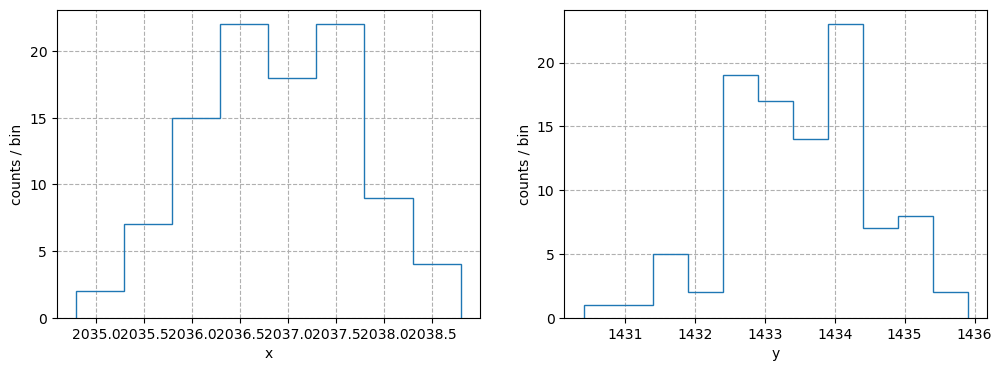

In [625]:
fig,axs = plt.subplots(1,2,figsize=[12,4])
for ax,name in zip(axs.flatten(),["x","y"]):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step',bins=np.arange(min(centroidResult[name]),max(centroidResult[name]),step=0.5))
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.12f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')

# Using the SMA connected LED

## Precision test on a single image
Goal: repeat the spotfinding algorithm on a single image to check that the measurement is repeatable

In [3]:
baseDir = "../data/mikeySpots/"

In [4]:
# img = np.array(Image.open(os.path.join(baseDir,os.listdir(baseDir)[0])))
# newImg = gaussian_filter(img,3)
# thresh = threshold_otsu(newImg)
# newImg[newImg < thresh] = 0
# plt.imshow(newImg)

In [5]:
%%time

allCents = np.array([])
chosenFile = random.sample(os.listdir(baseDir),1)[0]
print(f"Chosen file: {chosenFile}")
n=1
for _n in range(n):
    finder = spotB.SpotFinder(file_path=baseDir+chosenFile,max_counts=4000,min_energy=25,fboxsize=150,gaussian=True,gaussian_sig=3,otsu=True)
    centroid = finder.get_centroids()
    centroid['radius'] = centroid['fwhm']/(2*np.sqrt(2*np.log(2)))
    for k,v in zip(centroid.keys(),centroid.values()):
        centroid[k] = v[0]
    allCents = np.append(allCents,centroid)

Chosen file: 20251119_151828_10000.tif
CPU times: user 704 ms, sys: 144 ms, total: 849 ms
Wall time: 937 ms


In [6]:
vals = [tuple(x.values()) for x in allCents]
centroidResult = np.array(vals,dtype=nm_fm)

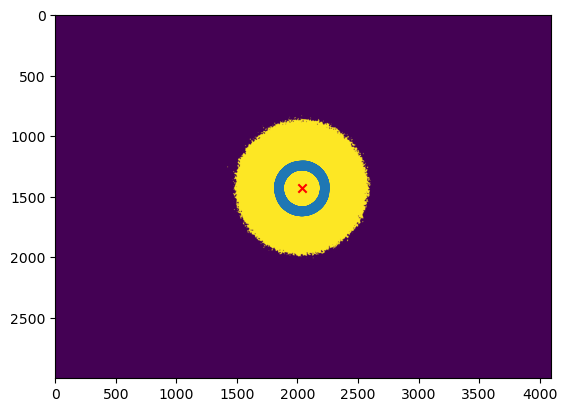

In [7]:
fig,ax = plt.subplots()
theta=np.arange(0,2*np.pi,step=0.01)
ax.imshow(finder.img,vmin=5,vmax=15)
ax.scatter(centroidResult['x'],centroidResult['y'],marker='x',color='red')
for x,y,r in zip(centroidResult['x'],centroidResult['y'],centroidResult['radius']):
    ax.scatter(x+r*np.cos(theta),y+r*np.sin(theta),ls='--')

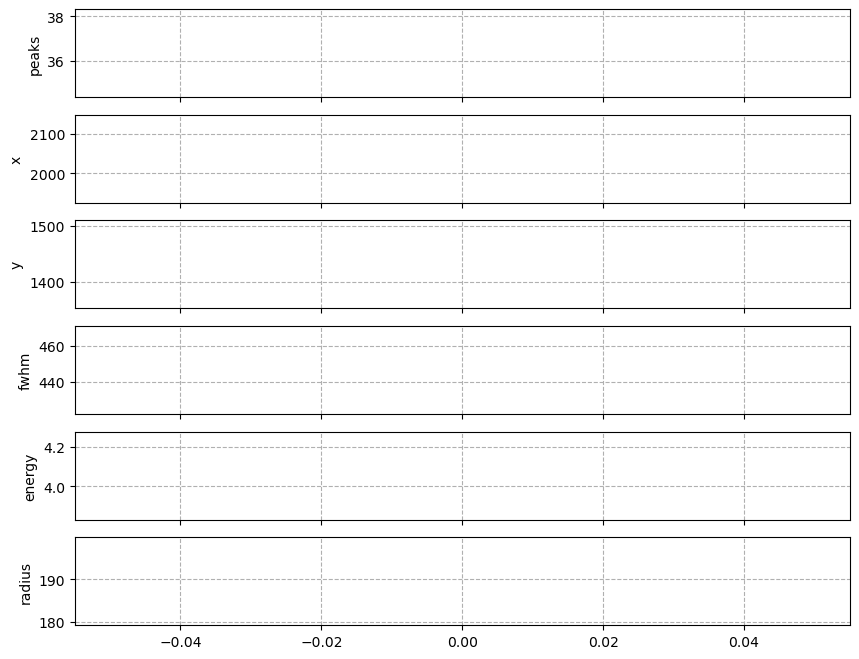

In [8]:
fig,axs = plt.subplots(6,figsize=[10,8],sharex=True)
for ax,name in zip(axs.flatten(),names):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')

For value peaks: 36.329, 36.329, 36.329, range over 1-sigma interval: 0.000000000000
For value x: 2036.904, 2036.904, 2036.904, range over 1-sigma interval: 0.000000000000
For value y: 1430.968, 1430.968, 1430.968, range over 1-sigma interval: 0.000000000000
For value fwhm: 446.380, 446.380, 446.380, range over 1-sigma interval: 0.000000000000
For value energy: 4.054, 4.054, 4.054, range over 1-sigma interval: 0.000000000000
For value radius: 189.560, 189.560, 189.560, range over 1-sigma interval: 0.000000000000


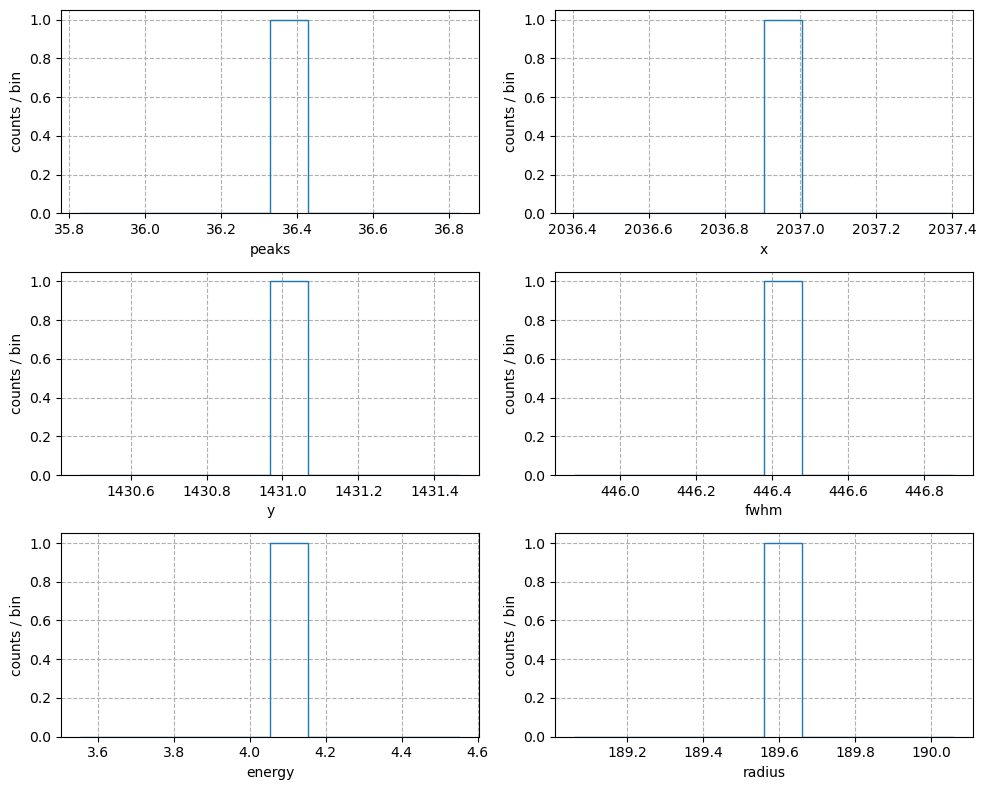

In [9]:
fig,axs = plt.subplots(3,2,figsize=[10,8])
for ax,name in zip(axs.flatten(),names):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step')
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.12f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')
fig.tight_layout()

## For multiple images

In [10]:
%%time

allCents = np.array([])
for f in os.listdir(baseDir):
    file_name = baseDir+f
    finder = spotB.SpotFinder(file_path=file_name,max_counts=4000,min_energy=25,fboxsize=150,gaussian=True,gaussian_sig=5,otsu=True)
    centroid = finder.get_centroids()
    centroid['radius'] = centroid['fwhm']/(2*np.sqrt(2*np.log(2)))
    for k,v in zip(centroid.keys(),centroid.values()):
        centroid[k] = v[0]
    allCents = np.append(allCents,centroid)

CPU times: user 1min 3s, sys: 6.5 s, total: 1min 10s
Wall time: 1min 13s


In [11]:
vals = [tuple(x.values()) for x in allCents]
centroidResult = np.array(vals,dtype=nm_fm)

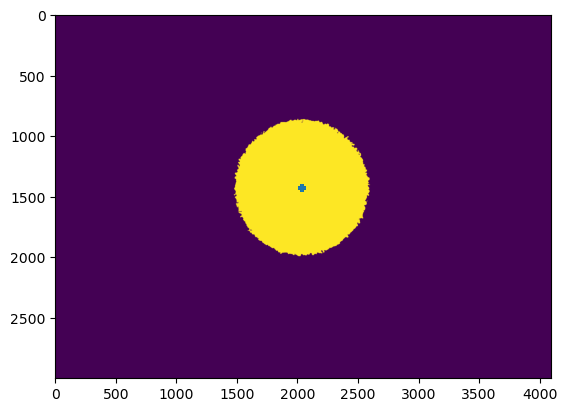

In [12]:
radii_plt=False
fig,ax = plt.subplots()
ax.imshow(finder.img,vmin=5,vmax=15)
ax.scatter(centroidResult['x'],centroidResult['y'],marker='+')
if radii_plt:
    for x,y,r in zip(centroidResult['x'],centroidResult['y'],centroidResult['radius']):
        ax.scatter(x+r*np.cos(theta),y+r*np.sin(theta),ls='--')

Text(0.5, 0, 'Image number')

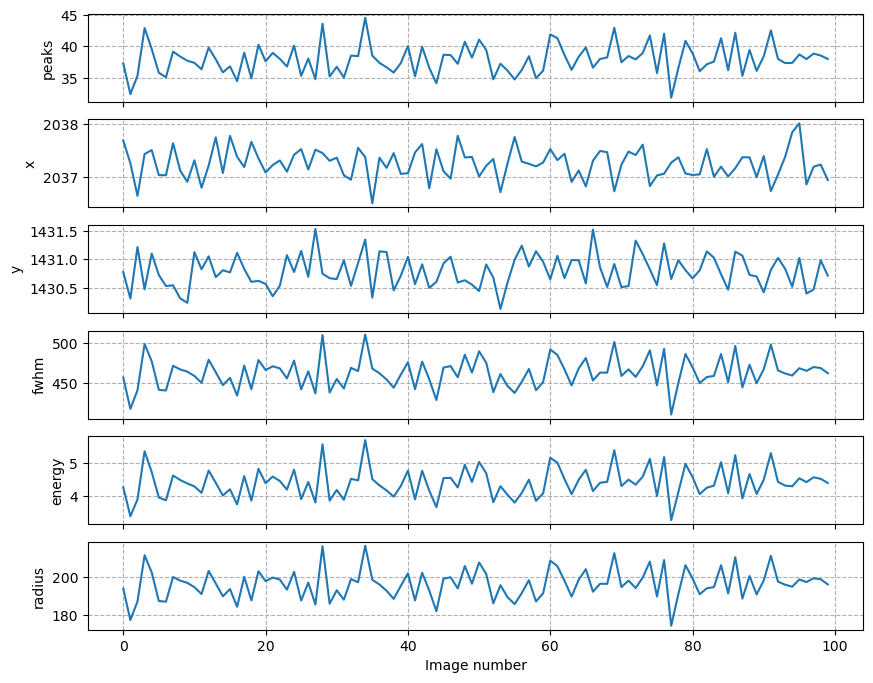

In [13]:
fig,axs = plt.subplots(6,figsize=[10,8],sharex=True)
for ax,name in zip(axs.flatten(),names):
    ax.plot(centroidResult[name])
    ax.set_ylabel(name)
    ax.grid(ls='--')
ax.set_xlabel("Image number")

For value peaks: 35.688, 37.969, 40.055, range over 1-sigma interval: 4.36696
For value x: 2037.010, 2037.265, 2037.524, range over 1-sigma interval: 0.51379
For value y: 1430.517, 1430.775, 1431.094, range over 1-sigma interval: 0.57654
For value fwhm: 444.122, 463.087, 478.792, range over 1-sigma interval: 34.67071
For value energy: 3.948, 4.395, 4.793, range over 1-sigma interval: 0.84456
For value radius: 188.601, 196.655, 203.324, range over 1-sigma interval: 14.72330


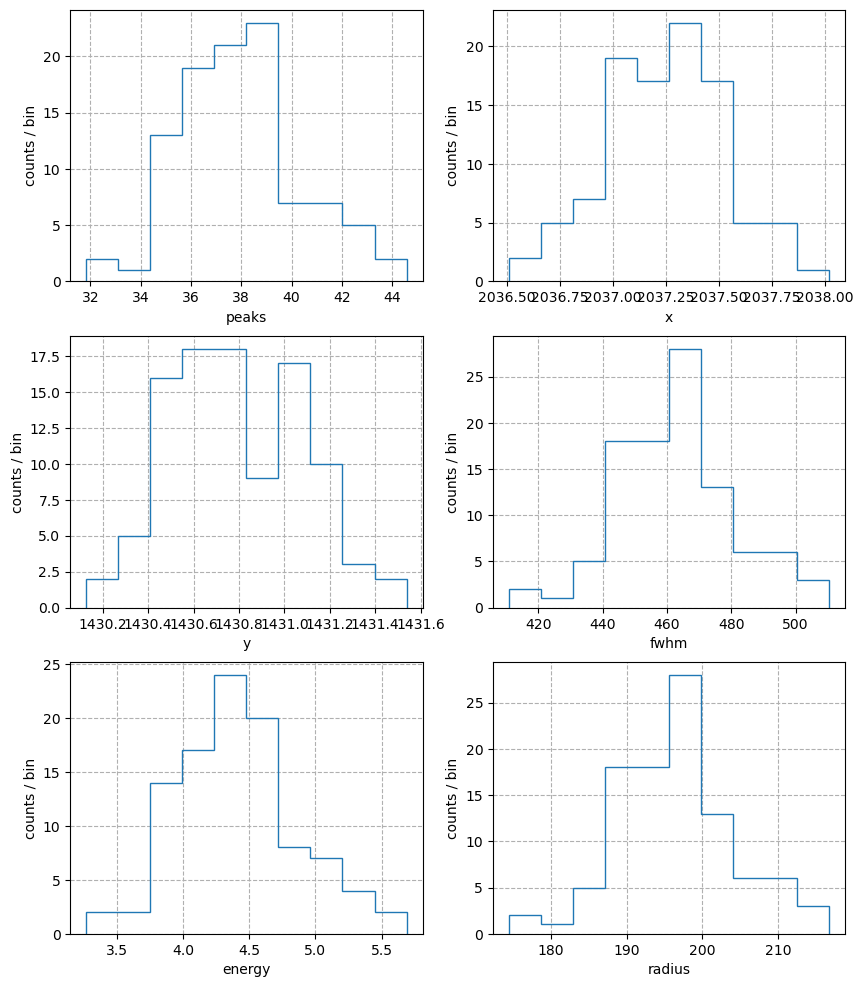

In [14]:
fig,axs = plt.subplots(3,2,figsize=[10,12])
for ax,name in zip(axs.flatten(),names):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step')
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.5f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')

For value x: 2037.010, 2037.265, 2037.524, range over 1-sigma interval: 0.513787536291
For value y: 1430.517, 1430.775, 1431.094, range over 1-sigma interval: 0.576537256607


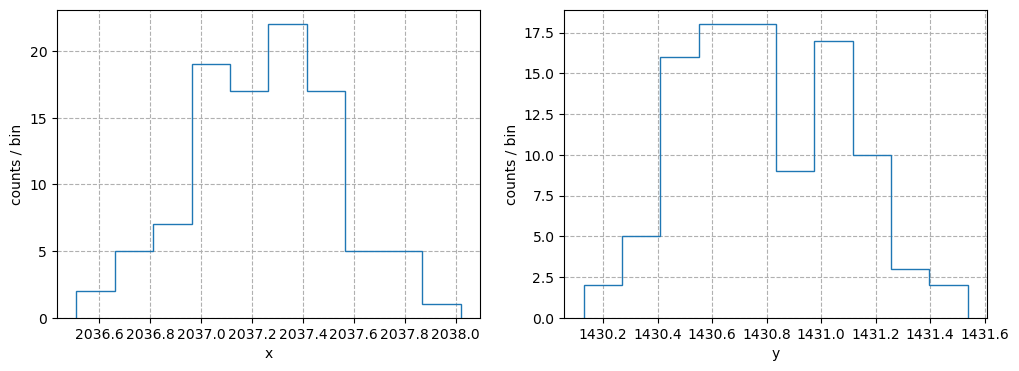

In [15]:
fig,axs = plt.subplots(1,2,figsize=[12,4])
for ax,name in zip(axs.flatten(),["x","y"]):
    low,med,high = np.nanpercentile(centroidResult[name],[16,50,84])
    ax.hist(centroidResult[name],histtype='step',)
    print("For value {}: {:.3f}, {:.3f}, {:.3f}, range over 1-sigma interval: {:.12f}".format(name,low,med,high,high-low))
    
    ax.set_xlabel(name)
    ax.set_ylabel("counts / bin")
    ax.grid(ls='--')

## testin' things

In [ ]:
algorithms = ["otsu", "li", "mean", "isodata", "triangle"]
algorithmResult = {}
sigmas = np.arange(1,6)

for a in algorithms:
    print(f"Algorithm={a}\n","-----"*5)
    r = {}
    r[a] = True
    sigmaResult = {}
    for sig in sigmas:
        print(f"Sigma={sig}")
        allCents = np.array([])
        for f in os.listdir(baseDir):
            file_name = baseDir+f
            finder = spotB.SpotFinder(file_path=file_name,max_counts=4000,min_energy=25,fboxsize=150,gaussian=True,gaussian_sig=sig,**r)
            centroid = finder.get_centroids()
            centroid['radius'] = centroid['fwhm']/(2*np.sqrt(2*np.log(2)))
            for k,v in zip(centroid.keys(),centroid.values()):
                centroid[k] = v[0]
            allCents = np.append(allCents,centroid)
        vals = [tuple(x.values()) for x in allCents]
        centroidResult = np.array(vals,dtype=nm_fm)
        sigmaResult[sig] = pd.DataFrame(centroidResult,columns=names)
    algorithmResult[a] = sigmaResult
np.save("allAlgorithms.npy", algorithmResult)

Algorithm=otsu
 -------------------------
Sigma=1
Sigma=2


In [ ]:
np.save("allAlgorithms.npy", algorithmResult)
# algorithmResult = np.load("allAlgorithms.npy")

In [ ]:
colorDict = {"otsu":"#0085ad", 
             "li":"#af272f", 
             "mean":"#4c8c2b", 
             "isodata":"#eaaa00", 
             "triangle":"#522506", 
             "yen":"#7F00FF"}

In [ ]:
fig,axs = plt.subplots(3,2,figsize=[10,12])

for a in algorithms[:5]:
    # print(f"{a} algorithm")
    # print("------"*10)
    std_arr = []
    for sig in sigmas:
        # print(f"{sig} sigma")
        # print("------"*5)
        stds = np.nanstd(algorithmResult[a][sig],axis=0)
        std_arr.append(stds)
    std_arr = np.array(std_arr)
    for i,ax in enumerate(axs.flatten()):
        ax.plot(sigmas,std_arr[:,i],label=a,color=colorDict[a],ls='--',marker="o")

for ax,name in zip(axs.flatten(),names):
    ax.set_xlabel("Sigma")
    ax.set_ylabel(f"std dev in {name} [pix]")
    ax.grid(ls='--')
    ax.legend()
fig.tight_layout()

In [ ]:
fig,axs = plt.subplots(2,figsize=[5,5],sharex=True)

for a in algorithms[:5]:
    # print(f"{a} algorithm")
    # print("------"*10)
    std_arr = []
    for sig in sigmas:
        # print(f"{sig} sigma")
        # print("------"*5)
        stds = np.nanstd(algorithmResult[a][sig],axis=0)
        std_arr.append(stds)
    std_arr = np.array(std_arr)
    for i,ax in enumerate(axs.flatten()):
        ax.plot(sigmas,std_arr[:,i+1]*0.1,label=a,color=colorDict[a],ls='--',marker="o")

axs[0].legend()
for ax,name in zip(axs.flatten(),["x","y"]):
    ax.set_ylabel(f"std dev in {name} [mm]")
    ax.grid(ls='--')
    ax.set_xticks(np.arange(1,6))
ax.set_xlabel("Sigma")
fig.tight_layout()

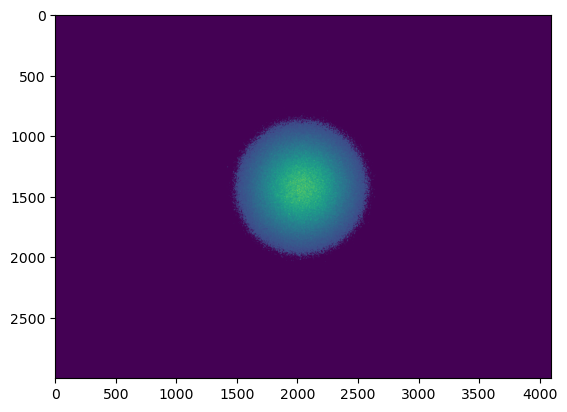

In [78]:
plt.imshow(finder.img)